<a href="https://colab.research.google.com/github/brandinho/Baysian-Q-Learning/blob/master/QValueNormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are Q-Values Normally Distributed?

We explore the effect that $N$, $\gamma$, and $\xi$ have on the normality of the Q-value distribution.

In [13]:
# Import Packages

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, bernoulli, shapiro, normaltest, anderson

Below we create the functions to generate the underlying reward distribution (which we define as a skew normal distribution). We also create the functions to calculate the Q-values.

In [26]:
# Distribution Functions

def generate_skew_data(loc, scale, skewness, n):
  assert n > 0
  return skewnorm.rvs(skewness, loc = loc, scale = scale, size = n)

def generate_bernoulli_data(p, n):
    assert n > 0
    return bernoulli.rvs(p, size = n)

def calculate_Q_value(rewards, gamma, sparsity):
    assert gamma >= 0 and gamma <= 1
    sparsity_offset = (sparsity + 1) // 2
    sparse_rewards = np.zeros_like(rewards)
    sparse_rewards[sparsity_offset::(sparsity + 1)] = rewards[sparsity_offset::(sparsity + 1)]
    discount_factors = gamma**np.arange(sparse_rewards.shape[0])
    return np.dot(sparse_rewards, discount_factors) / np.sum(discount_factors)

def calculate_Q_value_array(all_data, sample_size, gamma, sparsity, iterations):
  Q_values = []
  i = 0
  while len(Q_values) < iterations:
    Q_values.append(calculate_Q_value(all_data[i:i+sample_size], gamma, sparsity))
    i += sample_size
  return np.array(Q_values)

We also have to create the function to run the statistical tests of normality, which we do below:

In [27]:
# Statistical Tests for Normality

def print_normality_tests(Q_values, significance_level):
  def normal_or_not(true_or_false):
    if true_or_false:
      return "Normal"
    else:
      return "Non-Normal"

  assert significance_level > 0 and significance_level < 1
  shapiro_stat, shapiro_p = shapiro(Q_values)
  dagostino_stat, dagostino_p = normaltest(Q_values)
  anderson_darling_test = anderson(Q_values)
  anderson_critical = anderson_darling_test.critical_values[anderson_darling_test.significance_level == significance_level * 100][0]

  print("Using Sample Size: {} and Gamma: {}".format(sample_size, gamma))
  print("The following statistical tests yield:\n")
  
  print("Shapiro-Wilk: {}".format(normal_or_not(shapiro_p > significance_level)))
  print("D'Agostino's K^2: {}".format(normal_or_not(dagostino_p > significance_level)))
  print("Anderson-Darling: {}".format(normal_or_not(anderson_critical > anderson_darling_test.statistic)))

  print("\nThe statistical tests above use a {}% Confidence Interval\n".format((1-significance_level)*100))

Our last function we create is to plot the underlying reward distribution and the Q-value distribution.

In [24]:
# Plotting Functions

def plot_distributions(underlying_distribution, Q_values):
  sns.distplot(underlying_distribution, hist = False, kde_kws={"shade": True}, label = "Underlying (Dense) Distribution")
  sns.distplot(Q_values, hist = False, kde_kws={"shade": True}, label = "Q-value Distribution")
  plt.legend()

Now, we're ready to play around with some parameters and see under which conditions Q-values are normally distributed!!

Using Sample Size: 88 and Gamma: 0.99
The following statistical tests yield:

Shapiro-Wilk: Normal
D'Agostino's K^2: Normal
Anderson-Darling: Normal

The statistical tests above use a 95.0% Confidence Interval



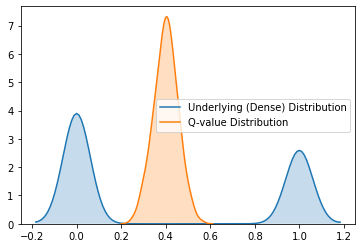

In [32]:
#@title Play Around with the the Parameters { form-width: "400px" }
# Set underlying distribution parameters
underlying_distribution = "Bernoulli" #@param ["Skew-Normal", "Bernoulli"]

if underlying_distribution == "Skew-Normal":
  loc = 0 #@param {type:"number"}
  scale = 2 #@param {type:"number"}
  skewness =  5#@param {type:"number"}
elif underlying_distribution == "Bernoulli":
  p = 0.4 #@param {type:"slider", min:0, max:1, step:0.01}

# Set sample size and gamma
sample_size = 88 #@param {type:"slider", min:1, max:100, step:1}
gamma = 0.99 #@param {type:"slider", min:0, max:1, step:0.01}
sparsity = 0 #@param {type:"slider", min:0, max:30, step:1}

# Generate the data for the underlying distribution
iterations = 500
n = sample_size * iterations
if underlying_distribution == "Skew-Normal":
  underlying_data = generate_skew_data(loc, scale, skewness, n)
elif underlying_distribution == "Bernoulli":
  underlying_data = generate_bernoulli_data(p, n)

significance_level = 0.05 #@param {type:"slider", min:0.01, max:0.99, step:0.01}

Q_values = calculate_Q_value_array(underlying_data, sample_size, gamma, sparsity, iterations)
plot_distributions(underlying_data, Q_values)
print_normality_tests(Q_values, significance_level)